### Recreate the findings from `Cultural influences on word meanings revealed through large-scale semantic alignment`

Article can be found [here](https://www.nature.com/articles/s41562-020-0924-8)

What we want: 
- compare how "close" a synthetic language is to real english and real source language. 

What we have:
- across different settings (real, synthetic)
    - across different languages 
        - the sim approach developed in paper above. 


In [1]:
import pandas as pd 

In [3]:
data_dir = '../data/NorthErualex_concepts/similarity/'
settings = ['synthetic_synthetic', 'real_real', 'synthetic_real']
langs = ['en','fr','de','ja', 'ru','et','hi']

pearsons = []

for setting in settings:
    for lang1 in langs:
        for lang2 in langs: 
            if (lang1 == lang2) & (setting != 'synthetic_real'):
                continue
            
            data_path = f'{data_dir}{setting}/{lang1}_{lang2}.csv'
            try: 
                df = pd.read_csv(data_path)
                # pearson correlation btwn sim and tr_sim
                pearson = df['sim'].corr(df['tr_sim'], method='pearson')
                pearsons.append({
                    'lang1': lang1,
                    'lang2': lang2,
                    'setting': setting,
                    'pearson': pearson
                })
            except:
                print('no data for ', data_path)

no data for  ../data/NorthErualex_concepts/similarity/synthetic_synthetic/en_ja.csv
no data for  ../data/NorthErualex_concepts/similarity/synthetic_synthetic/en_ru.csv
no data for  ../data/NorthErualex_concepts/similarity/synthetic_synthetic/fr_ja.csv
no data for  ../data/NorthErualex_concepts/similarity/synthetic_synthetic/fr_ru.csv
no data for  ../data/NorthErualex_concepts/similarity/synthetic_synthetic/de_ru.csv
no data for  ../data/NorthErualex_concepts/similarity/synthetic_synthetic/ja_ru.csv
no data for  ../data/NorthErualex_concepts/similarity/synthetic_synthetic/ru_en.csv
no data for  ../data/NorthErualex_concepts/similarity/synthetic_synthetic/ru_fr.csv
no data for  ../data/NorthErualex_concepts/similarity/synthetic_synthetic/ru_de.csv
no data for  ../data/NorthErualex_concepts/similarity/synthetic_synthetic/ru_ja.csv
no data for  ../data/NorthErualex_concepts/similarity/synthetic_synthetic/ru_et.csv
no data for  ../data/NorthErualex_concepts/similarity/synthetic_synthetic/ru

##### Hypothesis 1: on average, there is more similarity in the synthetic-synthetic setting than real-real setting.

First, we consider a simple exploration. To what extent does the synthetic distribution converge to one representation.

There are a few ways to study this. 



In [17]:
df = pd.DataFrame(pearsons)
df['id'] = df.apply(lambda x: '_'.join(sorted([x['lang1'], x['lang2']])), axis=1)

plotting_data = df.groupby(['id', 'setting'])['pearson'].mean().unstack()

In [25]:
plotting_data['has_eng'] = plotting_data.index.str.contains('en')
plotting_data.groupby('has_eng').mean()

setting,real_real,synthetic_real,synthetic_synthetic
has_eng,,,
False,0.272918,0.343105,0.389884
True,0.345602,0.406911,0.448509


/tmp/ipykernel_3796046/683254364.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plotting_data.index, rotation=90)


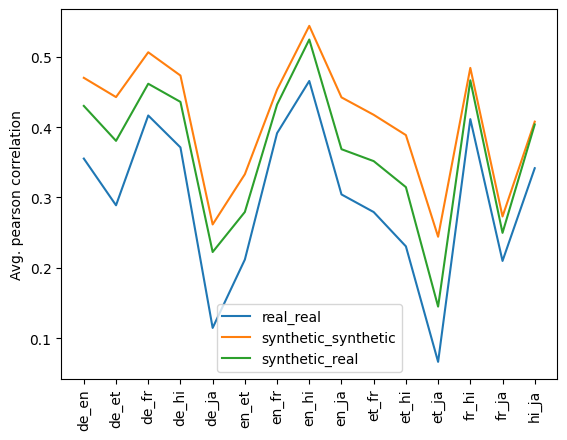

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(plotting_data.index, plotting_data['real_real'], label='real_real')
ax.plot(plotting_data.index, plotting_data['synthetic_synthetic'], label='synthetic_synthetic')
ax.plot(plotting_data.index, plotting_data['synthetic_real'], label='synthetic_real')
ax.set_xticklabels(plotting_data.index, rotation=90)
ax.set_ylabel('Avg. pearson correlation')
plt.legend()
plt.savefig('../visuals/north_euralex_concepts/pearson_correlation.jpg', dpi=300, bbox_inches='tight')